<a href="https://colab.research.google.com/github/yanting-jin/Transfer_Learning_Resnet50_GRADCAM/blob/main/Transfer_learning_Resnet50_ImageWoof2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [10]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import os
import copy
from copy import deepcopy
dict = {...}


plt.ion()   # interactive mode

# Loading data


In [3]:
# Load dataset from fastai 
! [ -e /content ] && pip install -Uqq fastai  
from fastai.vision.all import *
path = untar_data(URLs.IMAGEWOOF_320)

     |████████████████████████████████| 194kB 6.0MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 


In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/imagewoof2-320/train'),Path('/root/.fastai/data/imagewoof2-320/val')]

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
              

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

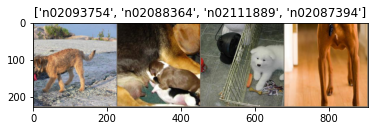

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':

              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.



In [8]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Train the model




In [11]:
from copy import deepcopy
dict = {...}
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.9669 Acc: 0.6849
val Loss: 0.9669 Acc: 0.6849

Epoch 1/14
----------
train Loss: 0.8399 Acc: 0.7321
val Loss: 0.8399 Acc: 0.7321

Epoch 2/14
----------
train Loss: 0.8299 Acc: 0.7435
val Loss: 0.8299 Acc: 0.7435

Epoch 3/14
----------
train Loss: 0.8266 Acc: 0.7445
val Loss: 0.8266 Acc: 0.7445

Epoch 4/14
----------
train Loss: 0.7992 Acc: 0.7494
val Loss: 0.7992 Acc: 0.7494

Epoch 5/14
----------
train Loss: 0.8429 Acc: 0.7384
val Loss: 0.8429 Acc: 0.7384

Epoch 6/14
----------
train Loss: 0.7276 Acc: 0.7713
val Loss: 0.7276 Acc: 0.7713

Epoch 7/14
----------
train Loss: 0.7202 Acc: 0.7709
val Loss: 0.7202 Acc: 0.7709

Epoch 8/14
----------
train Loss: 0.7078 Acc: 0.7757
val Loss: 0.7078 Acc: 0.7757

Epoch 9/14
----------
train Loss: 0.7169 Acc: 0.7754
val Loss: 0.7169 Acc: 0.7754

Epoch 10/14
----------
train Loss: 0.6938 Acc: 0.7799
val Loss: 0.6938 Acc: 0.7799

Epoch 11/14
----------
train Loss: 0.6977 Acc: 0.7757
val Loss: 0.6977 Acc: 0.7757

Epoch 12/14
----------
t

#Visualization

In [12]:


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]) +'\n'+
                'True: {}'.format(class_names[labels[j]]))
    
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

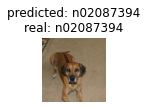

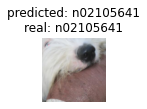

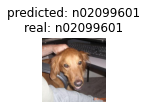

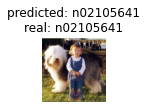

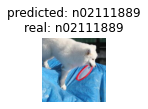

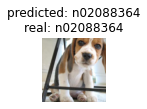

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Save the trained model & Reload the model 


In [ ]:
dir = '/content/TL_RestNet50_conv.pth'
torch.save(model_conv.state_dict(), dir)


# Evaluation

Identify the weakest classified class


Then visualize the layer activations using GRADCAM for a mislabeled image of your weakest class.


In [14]:
def get_predictions(model, dataloaders):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [15]:
y_pred, y_test = get_predictions(model_conv, dataloaders['val'])


In [16]:
def show_confusion_matrix(confusion_matrix, class_names):
  """
  identify the weakest classified class
  """

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.3f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

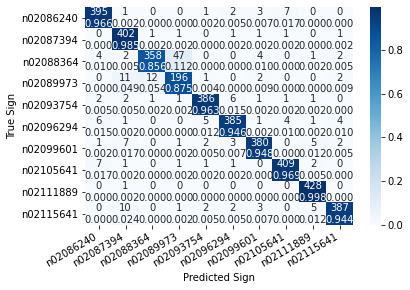

In [17]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)


In [18]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   n02086240       0.95      0.97      0.96       409
   n02087394       0.92      0.99      0.95       408
   n02088364       0.96      0.86      0.91       418
   n02089973       0.79      0.88      0.83       224
   n02093754       0.97      0.96      0.97       401
   n02096294       0.96      0.95      0.95       407
   n02099601       0.96      0.95      0.95       401
   n02105641       0.97      0.97      0.97       422
   n02111889       0.97      1.00      0.98       429
   n02115641       0.97      0.94      0.96       410

    accuracy                           0.95      3929
   macro avg       0.94      0.94      0.94      3929
weighted avg       0.95      0.95      0.95      3929



* The weakest class is n02089973, the accuracy of which is 87%
* Visualize one of the image in n02089973 in the validation set

In [19]:
incorrects = np.nonzero(y_pred.reshape((-1,)) != y_test)
incorrects.shape
indice = incorrects[[2]]

In [39]:
import os 
root = '/root/.fastai/data/imagewoof2-320/val/'
for path, subdirs, files in os.walk(root):
    for name in files:
        list = (os.path.join(path, name))

In [41]:
files[indice]

'n02089973_3272.JPEG'

In [22]:
image = '/root/.fastai/data/imagewoof2-320/val/n02089973/n02089973_1912.JPEG'

#GRAD-CAM

In [23]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import torch
from torch import nn
from torchvision import models, transforms


In [24]:
# Opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0)
])

In [25]:
class Flatten(nn.Module):
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

In [30]:
model = models.resnet50(pretrained=True)
#model = model_conv
features_fn = nn.Sequential(*list(model.children())[:-2])
classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))

model = model.eval()
model = model.cuda()

In [31]:
def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal

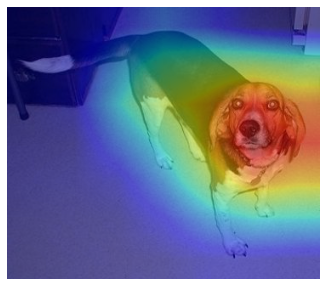

In [60]:
img_path = '/root/.fastai/data/imagewoof2-320/val/n02089973/n02089973_1912.JPEG'
img_tensor = read_tensor(img_path)
pp, cc = torch.topk(nn.Softmax(dim=1)(model(img_tensor.cuda())), 3)

plt.figure(figsize=(15, 5))
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    plt.plot()
    sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
    img = Image.open(img_path)
    sal = Image.fromarray(sal)
    sal = sal.resize(img.size, resample=Image.LINEAR)
    
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(np.array(sal), alpha=0.5, cmap='jet')
plt.show()